In [12]:
import numpy as np
import scipy.sparse as sp
import os
import sys
from vis import plot_superadj

In [13]:
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn import preprocessing 
def load_assortative(dataset="cora"):
    import pickle as pkl
    import networkx as nx
    import scipy.sparse as sp
    import torch

    def parse_index_file(filename):
        index = []
        for line in open(filename):
            index.append(int(line.strip()))
        return index

    def sample_mask(idx, l):
        """Create mask."""
        mask = np.zeros(l)
        mask[idx] = 1
        return np.array(mask, dtype=np.bool)

    if dataset in ["cora", "citeseer", "pubmed"]:
        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []

        for i in range(len(names)):
            '''
            fix Pickle incompatibility of numpy arrays between Python 2 and 3
            https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
            '''
            with open("/data/liuyue/New/SBM/mySBM/data/{}/ind.{}.{}".format(dataset, dataset, names[i]), 'rb') as rf:
                u = pkl._Unpickler(rf)
                u.encoding = 'latin1'
                cur_data = u.load()
                objects.append(cur_data)
            # objects.append(
            #     pkl.load(open("data/ind.{}.{}".format(dataset, names[i]), 'rb')))
        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = parse_index_file(
            "/data/liuyue/New/SBM/mySBM/data/{}/ind.{}.test.index".format(dataset, dataset))
        test_idx_range = np.sort(test_idx_reorder)


        if dataset == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(
                min(test_idx_reorder), max(test_idx_reorder) + 1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range - min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range - min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        features = torch.FloatTensor(np.array(features.todense()))
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
        
        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]
        
        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y) + 500)

        train_mask = sample_mask(idx_train, labels.shape[0])
        val_mask = sample_mask(idx_val, labels.shape[0])
        test_mask = sample_mask(idx_test, labels.shape[0])

        y_train = np.zeros(labels.shape)
        y_val = np.zeros(labels.shape)
        y_test = np.zeros(labels.shape)
        y_train[train_mask, :] = labels[train_mask, :]
        y_val[val_mask, :] = labels[val_mask, :]
        y_test[test_mask, :] = labels[test_mask, :]

        adj = adj.toarray()
        labels = labels.argmax(1)
        # idx = labels.argsort(0)
        # adj = adj[idx, :][:, idx]
        # labels = labels[idx]
        # features = features[idx]

        adj = sp.coo_matrix(adj)
        features = sp.coo_matrix(features)

        return adj, features, labels
    elif dataset == "wiki":
        f = open('/data/liuyue/New/SBM/mySBM/data/wiki/graph.txt','r')
        adj, xind, yind = [], [], []
        for line in f.readlines():
            line = line.split()
            
            xind.append(int(line[0]))
            yind.append(int(line[1]))
            adj.append([int(line[0]), int(line[1])])
        f.close()
        ##print(len(adj))

        f = open('/data/liuyue/New/SBM/mySBM/data/wiki/group.txt','r')
        label = []
        for line in f.readlines():
            line = line.split()
            label.append(int(line[1]))
        f.close()

        f = open('/data/liuyue/New/SBM/mySBM/data/wiki/tfidf.txt','r')
        fea_idx = []
        fea = []
        adj = np.array(adj)
        adj = np.vstack((adj, adj[:,[1,0]]))
        adj = np.unique(adj, axis=0)
        
        labelset = np.unique(label)
        labeldict = dict(zip(labelset, range(len(labelset))))
        label = np.array([labeldict[x] for x in label])
        adj = sp.coo_matrix((np.ones(len(adj)), (adj[:,0], adj[:,1])), shape=(len(label), len(label)))

        for line in f.readlines():
            line = line.split()
            fea_idx.append([int(line[0]), int(line[1])])
            fea.append(float(line[2]))
        f.close()

        fea_idx = np.array(fea_idx)
        features = sp.coo_matrix((fea, (fea_idx[:,0], fea_idx[:,1])), shape=(len(label), 4973)).toarray()
        scaler = preprocessing.MinMaxScaler()
        #features = preprocess.normalize(features, norm='l2')
        features = scaler.fit_transform(features)
        # features = torch.FloatTensor(features)
        features = sp.coo_matrix(features)

        return adj, features, label
    elif dataset in ["ogbn-arxiv", "ogbn-products"]:
        dataset = DglNodePropPredDataset(name="{}".format(dataset))
        g, labels = dataset[0]
        edge_indices = g.adj_sparse(fmt="coo")
        n, m = labels.shape[0], edge_indices[0].shape[0]
        adj = sp.coo_matrix((np.ones(m), (edge_indices[0].numpy(), edge_indices[1].numpy())), shape=(n,n))
        features = g.ndata["feat"]
        features = sp.coo_matrix(features)

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.view(-1)
            else:
                labels = labels.argmax(1)
        labels = labels.numpy()
        return adj, features, labels
    elif dataset in ["amazon-photo", "amazon-computers", "cora-full"]:
        map2names = {
            "amazon-photo": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_photo.npz",
            "amazon-computers": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_computers.npz",
            "cora-full": "/data/liuyue/New/SBM/mySBM/data/cora_full.npz",
        }

        data = np.load(map2names[dataset])
        # print(list(data.keys()))
        adj_data, adj_indices, adj_indptr, adj_shape = data["adj_data"], data["adj_indices"], data["adj_indptr"], data["adj_shape"]
        attr_data, attr_indices, attr_indptr, attr_shape = data["attr_data"], data["attr_indices"], data["attr_indptr"], data["attr_shape"]
        labels = data["labels"]

        adj = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape).tocoo()
        features = sp.csr_matrix((attr_data, attr_indices, attr_indptr), shape=attr_shape).tocoo()

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.reshape(-1)
            else:
                labels = labels.argmax(1)

        return adj, features, labels
    else:
        raise NotImplementedError()

In [17]:
datasets = [
    "cora",
    "citeseer",
    "wiki",
    "pubmed",
    "amazon-photo",
    "amazon-computers",
    "cora-full",
    "ogbn-arxiv",
    "ogbn-products",
]

In [19]:
for dataset in datasets:
    print("#"*5, dataset, "#"*5)
    
    adj_raw, features_raw, labels_raw = load_assortative(dataset)
    labels_s = np.sort(np.unique(labels_raw))
    nclass = labels_s.shape[0]
    node_sizes = []
    for cls_id in labels_s:
        node_sizes.append(np.where(labels_raw==cls_id)[0].shape[0])
    node_sizes = np.array(node_sizes)

    print("Number of Nodes: {}".format(adj_raw.shape[0]))
    print("Number of Edges: {}".format(adj_raw.sum()))
    print("Dim of features: {}".format(features_raw.shape[-1]))
    print("Number of Classes: {}".format(nclass))
    print("Number of nodes in each class: {}".format(node_sizes))
    
    print("Average Size of Communities: {:d}+-{:.2f}".format(int(np.mean(node_sizes)), np.std(node_sizes)))
    print("Imbalanced Rate: {:.2f}".format(np.min(node_sizes)/np.max(node_sizes)))
    print()
    
#     print("#"*20)

##### cora #####
Number of Nodes: 2708
Number of Edges: 10556
Dim of features: 1433
Number of Classes: 7
Number of nodes in each class: [351 217 418 818 426 298 180]
Average Size of Communities: 386+-196.11
Imbalanced Rate: 0.22

##### citeseer #####
Number of Nodes: 3327
Number of Edges: 9228
Dim of features: 3703
Number of Classes: 6
Number of nodes in each class: [264 590 668 701 596 508]
Average Size of Communities: 554+-143.69
Imbalanced Rate: 0.38

##### wiki #####
Number of Nodes: 2405
Number of Edges: 24357.0
Dim of features: 4973
Number of Classes: 17
Number of nodes in each class: [ 92 406 203 103  10 361 157  53 109  11 269 179   9  30  77 228 108]
Average Size of Communities: 141+-116.25
Imbalanced Rate: 0.02

##### pubmed #####
Number of Nodes: 19717
Number of Edges: 88651
Dim of features: 500
Number of Classes: 3
Number of nodes in each class: [4103 7739 7875]
Average Size of Communities: 6572+-1746.96
Imbalanced Rate: 0.52

##### amazon-photo #####
Number of Nodes: 7650


In [38]:
print((np.array(node_sizes)>=400).sum())

17


In [39]:
def sample_uniform_comms(adj, features, labels, nclass_s=10, num_nodes_per_comm=200, seed=None):
    labels_s = np.sort(np.unique(labels))
    nclass = labels_s.shape[0]
    node_sizes = []
    for cls_id in labels_s:
        node_sizes.append(np.where(labels==cls_id)[0].shape[0])
    node_sizes = np.array(node_sizes)

    large_comms = np.where(node_sizes>=num_nodes_per_comm)[0]
    np.random.RandomState(seed=seed).shuffle(large_comms)
    comms_s = large_comms[:nclass_s]
    n, d = features.shape
    mask = np.zeros(n)
    for i in range(nclass_s):
        comm = comms_s[i]
        node_ids = np.where(labels==comm)[0][:num_nodes_per_comm]
        mask[node_ids] = 1

    mask = np.nonzero(mask)[0]
    
    nodeid_new2old = {k:v for k,v in enumerate(mask)}
    
    adj = adj.toarray()[mask,:][:,mask]
    adj = sp.coo_matrix(adj)
    features = features.toarray()[mask]
    features = sp.coo_matrix(features)
    labels = labels[mask]
    
    old2new = {} #将社区id重新从0开始计数
    cur = 0
    for i, l in enumerate(labels):
        if not l in old2new.keys():
            old2new[l] = cur
            cur += 1
        labels[i] = old2new[l]
            
    
    return adj, features, labels, nodeid_new2old

In [48]:
seed=2
adj, features, labels, nodeid_new2old = sample_uniform_comms(adj_raw, features_raw, labels_raw, nclass_s=5, num_nodes_per_comm=400, seed=seed)

100%|██████████| 100/100 [00:00<00:00, 219.26it/s]


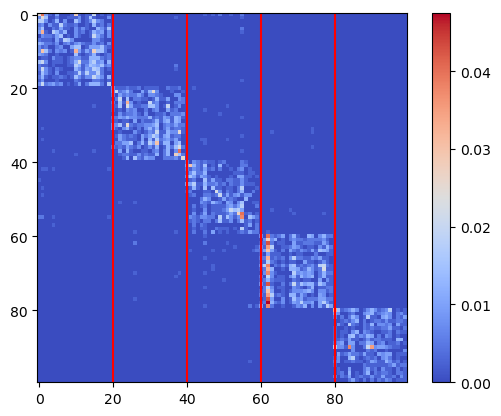

In [49]:
plot_superadj(adj, K=100, sparse=True, labels=labels, dataset=dataset, vline=True)

In [50]:
def sample_classes(adj, features, labels, nodeid_new2old, rate=0.1, seed=None):
    n, d = features.shape
    labels_s = np.sort(np.unique(labels))
#     print(labels_s)
    nclass = labels_s.shape[0]
    assert nclass > 1
    
    mask = np.zeros(n)
    for cls_id in labels_s:
        exist_prob = rate + (1.0 - rate) / (nclass-1) * cls_id
        node_ids = np.where(labels==cls_id)[0]
        n_ = node_ids.shape[0]
#         print(n_)
        mask_ = np.random.RandomState(seed=seed).binomial(1, exist_prob, size=(n_))
        
        mask[node_ids] = mask_
    
    mask = np.nonzero(mask)[0]
    
    adj = adj.toarray()[mask, :][:, mask]
    adj = sp.coo_matrix(adj)
    features = features.toarray()[mask]
    features = sp.coo_matrix(features)
    labels = labels[mask]

    mask = [nodeid_new2old[v] for v in mask]
    
    return adj, features, labels, mask

In [51]:
minimum_rention_rates = np.arange(0.1, 1.0, 0.1)
for rention_rate in minimum_rention_rates:
    adj_s, features_s, labels_s, mask = sample_classes(adj, features, labels, nodeid_new2old,rate=rention_rate, seed=seed)
    print(adj_s.shape, adj_s.sum())
#     plot_superadj(adj_s2, K=100, sparse=False, labels=labels_s2, dataset=dataset+"_{}".format(rention_rate), vline=True)
    np.savez("{}_{:.1f}_{:d}_5.npz".format(dataset, rention_rate, seed), data=adj_s.data, row=adj_s.row, col=adj_s.col, features=features_s.toarray(), labels=labels_s, mask=mask)

(1103, 1103) 1567.0
(1200, 1200) 1780.0
(1291, 1291) 1925.0
(1423, 1423) 2202.0
(1516, 1516) 2440.0
(1640, 1640) 2791.0
(1723, 1723) 3041.0
(1823, 1823) 3464.0
(1914, 1914) 3889.0
